<a href="https://colab.research.google.com/github/kjmobile/lb/blob/main/Ch10_deeplearning_lab_Part1_A_GPU_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning


In [6]:
!pip install --upgrade pip
!pip install torchinfo torchvision torchmetrics
!pip install pytorch_lightning
!pip install islp

In [7]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

### Torch-Specific Imports


In [8]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset


In [9]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary


In [11]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger


In [12]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


INFO:lightning_fabric.utilities.seed:Seed set to 0


In [13]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

In [14]:
from ISLP.torch import (SimpleDataModule,SimpleModule, ErrorTracker, rec_num_workers)

In [15]:
from ISLP.torch.imdb import (load_lookup,load_tensor,load_sparse,load_sequential)

In [16]:
from glob import glob
import json


## Single Layer Network on Hitters Data


In [17]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]


In [18]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy() ###ch
Y = Hitters['Salary'].to_numpy()


In [19]:
(X_train,
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

### Linear Models


In [20]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean() ##check how much error in dolloars

259.7152883314631

In [21]:
# same as below
# from sklearn.metrics import mean_absolute_error as mae
# mae(Yhat_test, Y_test)

In [22]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000) #Q1
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

In [23]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n #Q2
param_grid = {'lasso__alpha': np.exp(np.linspace(0, np.log(0.01), 100))
             * lam_max}

In [24]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(standard_lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

In [25]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean() #Q3 now how much mae  in dollar after applying cv on lasso?

235.6754837478029

### Specifying a Network: Classes and Inheritance - See illustration in c10-nn


In [26]:
class HittersModel(nn.Module): #Q4, Q5

    def __init__(self, input_size):
        super(HittersModel, self).__init__() #Q6
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))


In [27]:
hit_model = HittersModel(X.shape[1])


In [28]:
summary(hit_model,                     #Q8, #Q9
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])    ### num params, why 1000. sequential(), hidden layer, output layer, Relu and Dropout are "operations" Q10 50 bias-terms


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return F.linear(input, self.weight, self.bias)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [29]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

In [30]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t) #Q12


In [31]:
max_num_workers = rec_num_workers()

In [32]:
from ISLP.torch import (SimpleDataModule,SimpleModule, ErrorTracker, rec_num_workers)

hit_dm = SimpleDataModule(hit_train,    #Q11 #Q13
                          hit_test,
                          batch_size=32, #Q14
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)

In [33]:
hit_module = SimpleModule.regression(hit_model,
                           metrics={'mae':MeanAbsoluteError()}) # Q17


In [34]:
hit_logger = CSVLogger('logs', name='hitters')

In [36]:
from pytorch_lightning import Trainer

hit_trainer = Trainer(deterministic=False,    #Q15
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm) #  Q16

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params | Mode
----------------------------------------------
0 | model | HittersModel | 1.1 K  | eval
1 | loss  | MSELoss      | 0      | eval
----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
0         Modules in train mode
8         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [37]:
hit_trainer.test(hit_module, datamodule=hit_dm) ### MAE now


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │        94260.5625         │
│         test_mae          │     218.5134735107422     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 94260.5625, 'test_mae': 218.5134735107422}]

In [39]:
hit_logger.experiment.log_metrics

<bound method _ExperimentWriter.log_metrics of <pytorch_lightning.loggers.csv_logs.ExperimentWriter object at 0x7b6311344910>>

In [40]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [41]:
hit_results

,epoch,step,test_loss,test_mae,train_loss,train_mae_epoch,train_mae_step,valid_loss,valid_mae
0,0,4,NaN,NaN,NaN,NaN,605.194153,NaN,NaN
1,0,5,NaN,NaN,NaN,NaN,NaN,178674.343750,275.420380
2,0,5,NaN,NaN,709967.0,580.683228,NaN,NaN,NaN
3,1,9,NaN,NaN,NaN,NaN,193.385147,NaN,NaN
4,1,11,NaN,NaN,NaN,NaN,NaN,126903.140625,234.125183
...,...,...,...,...,...,...,...,...,...
156,49,294,NaN,NaN,NaN,NaN,131.636398,NaN,NaN
157,49,299,NaN,NaN,NaN,NaN,168.727707,NaN,NaN
158,49,299,NaN,NaN,NaN,NaN,NaN,94260.562500,218.513474
159,49,299,NaN,NaN,83539.0,198.152649,NaN,NaN,NaN


In [42]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='*',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

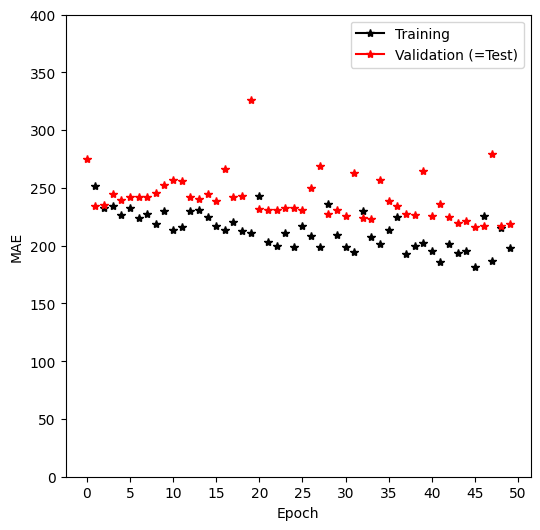

In [43]:
fig, ax = subplots(1, 1, figsize=(6, 6)) #Q18
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [44]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean() #Q19

tensor(218.5135, grad_fn=<MeanBackward0>)

### Cleanup


In [ ]:
del(Hitters,  #Q20
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)


## Multilayer Network on the MNIST Digit Data


In [45]:
from torchvision.datasets import MNIST, CIFAR100

(mnist_train,                                #Q22, Q23. ### num records
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]
mnist_train



  0%|          | 0.00/9.91M [00:00<?, ?B/s]
  0%|          | 32.8k/9.91M [00:00<00:53, 183kB/s]
  1%|          | 65.5k/9.91M [00:00<00:54, 182kB/s]
  1%|          | 98.3k/9.91M [00:00<00:54, 181kB/s]
  2%|▏         | 197k/9.91M [00:00<00:29, 324kB/s] 
  4%|▍         | 393k/9.91M [00:00<00:15, 598kB/s]
  8%|▊         | 786k/9.91M [00:01<00:08, 1.13MB/s]
 16%|█▌        | 1.57M/9.91M [00:01<00:03, 2.18MB/s]
 32%|███▏      | 3.15M/9.91M [00:01<00:01, 4.25MB/s]
 63%|██████▎   | 6.26M/9.91M [00:01<00:00, 8.29MB/s]
100%|██████████| 9.91M/9.91M [00:01<00:00, 5.46MB/s]

  0%|          | 0.00/28.9k [00:00<?, ?B/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]

  0%|          | 0.00/1.65M [00:00<?, ?B/s]
  2%|▏         | 32.8k/1.65M [00:00<00:08, 183kB/s]
  4%|▍         | 65.5k/1.65M [00:00<00:08, 182kB/s]
  8%|▊         | 131k/1.65M [00:00<00:05, 264kB/s] 
 16%|█▌        | 262k/1.65M [00:00<00:03, 445kB/s]
 32%|███▏      | 524k/1.65M [00:00<00:01, 807kB/s]
100%|██████████| 1.65M/1.65M [00

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [47]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)


In [48]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break


X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


# sample handwriting image per category

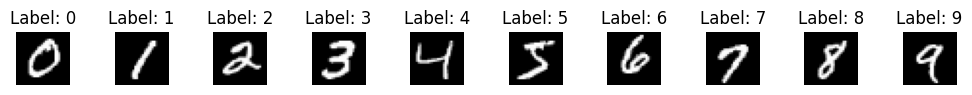

In [49]:
import matplotlib.pyplot as plt

found = {}
for img, label in zip(mnist_train.data, mnist_train.targets):
    lbl = label.item()
    if lbl not in found:
        found[lbl] = img
    if len(found) == 10:
        break

fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axes[i].imshow(found[i], cmap='gray')
    axes[i].set_title(f"Label: {i}")
    axes[i].axis('off')
plt.tight_layout()


In [50]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),  ### 256, 128 determined by... domain experience; rule of thusm: begin experiements with 256, 128, 64...
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

In [51]:
mnist_model = MNISTModel()


In [52]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [53]:
mnist_module = SimpleModule.classification(mnist_model,num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')


In [56]:
mnist_trainer = Trainer(deterministic=False,
                        max_epochs=30,
                        logger=mnist_logger,
                        enable_progress_bar=True,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/MNIST/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


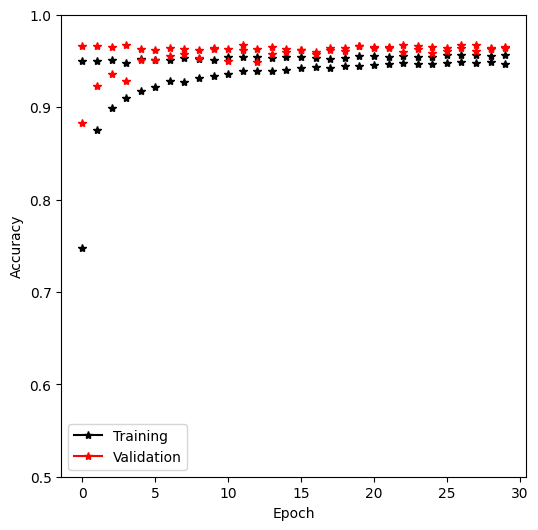

In [57]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));


In [58]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm) #Q26.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9642999768257141     │
│         test_loss         │    0.17663265764713287    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.17663265764713287, 'test_accuracy': 0.9642999768257141}]

###  Individual item prediction check :                            

In [59]:
mnist_module.eval() # Set the module in evaluation mode.
test_loader = mnist_dm.test_dataloader()
X_batch, y_batch = next(iter(test_loader))

with torch.no_grad(): #Context-manager that disables  back propagating gradient calculation
    logits = mnist_module(X_batch)
    preds = torch.argmax(logits, dim=1)

print(f"Predicted: {preds[0].item()}, Actual: {y_batch[0].item()}")
if preds[0].item() == y_batch[0].item():
    print("Correct")
else:
    print("Wrong")

Predicted: 7, Actual: 7
Correct


### show  pred vs. actual for 10 first samples from test set

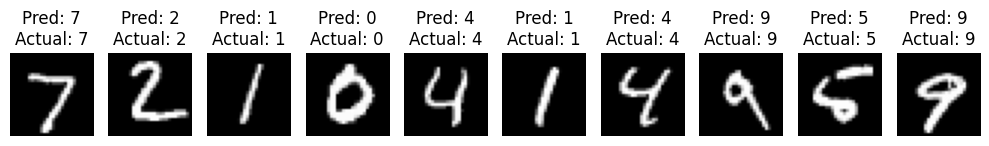

In [60]:
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
    logits = mnist_module(X_batch)
    preds = torch.argmax(logits, dim=1)

num_samples = 10
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_batch[i].squeeze(), cmap='gray')

    # Check correctness
    pred = preds[i].item()
    actual = y_batch[i].item()
    color = 'red' if pred != actual else 'black'

    plt.title(f"Pred: {pred}\nActual: {actual}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Multiclass Logistic Regression (Not a Neural Net; no hidden layer, no activation function)

In [61]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model,
                                         num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [64]:
mlr_trainer = Trainer(deterministic=False,
                      max_epochs=30,
                      enable_progress_bar=True,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [65]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9083999991416931     │
│         test_loss         │    0.3777032792568207     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3777032792568207, 'test_accuracy': 0.9083999991416931}]

#### 10 first samples from test set

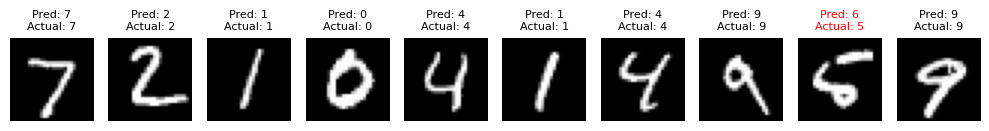

In [66]:
test_loader = mnist_dm.test_dataloader()
X_batch, y_batch = next(iter(test_loader))

mlr_module.eval()  # Set to evaluation mode
with torch.no_grad():
    logits = mlr_module(X_batch)               # Use the trained mlr_module
    preds = torch.argmax(logits, dim=1)        # Get predicted class index

num_samples = min(10, X_batch.shape[0])
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_batch[i].squeeze(), cmap='gray')

    pred = preds[i].item()
    actual = y_batch[i].item()
    color = 'red' if pred != actual else 'black'

    plt.title(f"Pred: {pred}\nActual: {actual}", color=color, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [67]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

## Convolutional Neural Networks


In [68]:
(cifar_train,
 cifar_test) = [CIFAR100(root="data",
                         train=train,
                         download=True)
             for train in [True, False]] #Q27

100%|██████████| 169M/169M [00:10<00:00, 15.7MB/s]


In [69]:
cifar_train

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train

In [70]:
cifar_train.data.shape ### how many chanels

(50000, 32, 32, 3)

In [71]:
transform = ToTensor() ### Convert image (H, W, C, uint8) to tensor (C, H, W, float32) scaled to [0,1]
cifar_train_X = torch.stack([transform(x) for x in
                            cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                            torch.tensor(cifar_test.targets))

In [72]:
cifar_train_X.shape ### channels color

torch.Size([50000, 3, 32, 32])

In [73]:
cifar_dm = SimpleDataModule(cifar_train,
                            cifar_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=128)


In [74]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()): #train_dataloader() fetches the training data in batches.
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1: ### show only two batches
        break


X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


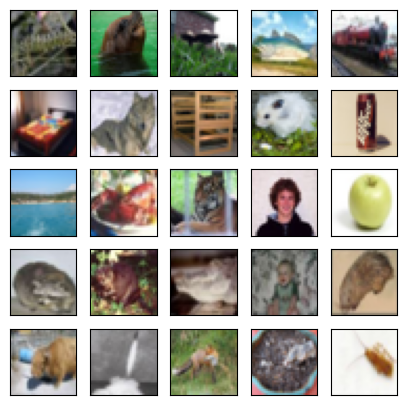

In [75]:
fig, axes = subplots(5, 5, figsize=(5,5))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                      [1,2,0]),
                                      interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])


In [76]:
class BuildingBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels):

        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))


In [77]:
class CIFARModel(nn.Module): #Q30

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)


In [78]:
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [79]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
# In PyTorch, parameters() collects all the hidden weights and biases inside the model and passes them to the optimizer.
# This allows the optimizer to know exactly which parameters to update during training.

cifar_module = SimpleModule.classification(cifar_model,
                                    num_classes=100,
                                    optimizer=cifar_optimizer)
cifar_logger = CSVLogger('logs', name='CIFAR100')


In [81]:
cifar_trainer = Trainer(deterministic=False,    # takes more than 10 minutes don't run again.
                        max_epochs=30,
                        logger=cifar_logger,
                        enable_progress_bar=True,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,
                  datamodule=cifar_dm)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


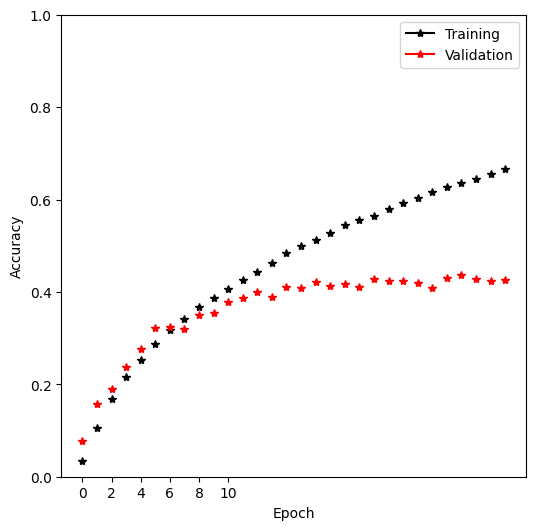

In [82]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

In [83]:
cifar_trainer.test(cifar_module,
                   datamodule=cifar_dm)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4293999969959259     │
│         test_loss         │    2.4336419105529785     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.4336419105529785, 'test_accuracy': 0.4293999969959259}]

### Hardware Acceleration :using apple M1/M2 GPU only if available


In [ ]:
# try:
#     for name, metric in cifar_module.metrics.items():
#         cifar_module.metrics[name] = metric.to('mps')
#     cifar_trainer_mps = Trainer(accelerator='mps',
#                                 deterministic=True,
#                                 enable_progress_bar=False,
#                                 max_epochs=30)
#     cifar_trainer_mps.fit(cifar_module,
#                           datamodule=cifar_dm)
#     cifar_trainer_mps.test(cifar_module,
#                           datamodule=cifar_dm)
# except:
#     pass

## Using Pretrained CNN Models


In [91]:
import os, urllib.request, requests #added to create book_images folder
from glob import glob

os.makedirs("book_images", exist_ok=True)

r = requests.get("https://api.github.com/repos/kjmobile/data/contents/img/book_images")
urls = [f["download_url"] for f in r.json() if f["name"].lower().endswith((".png", ".jpg", ".jpeg"))]

for url in urls:
    urllib.request.urlretrieve(url, f"book_images/{url.split('/')[-1]}")




In [93]:
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted(glob("book_images/*"))
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([6, 3, 224, 224])

In [94]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [95]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [96]:
img_preds = resnet_model(imgs)


In [97]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]


In [102]:
import urllib.request, json
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"   # imagenet download
urllib.request.urlretrieve(url, "imagenet_class_index.json")

with open("imagenet_class_index.json") as f:
    labs = json.load(f)


In [103]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()


In [104]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))


Image: book_images/Cape_Weaver.jpg
      label      prob
0   jacamar  0.297500
1     macaw  0.068107
2  lorikeet  0.051104
Image: book_images/Flamingo.jpg
            label      prob
0        flamingo  0.609514
1       spoonbill  0.013586
2  American_egret  0.002132
Image: book_images/Hawk_Fountain.jpg
            label      prob
0            kite  0.184681
1           robin  0.084021
2  great_grey_owl  0.061274
Image: book_images/Hawk_cropped.jpg
            label      prob
0            kite  0.453834
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097196
2  Tibetan_terrier  0.032819
Image: book_images/Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


In [ ]:
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)